# Titanic EDA

This is a machine learning exercise to predict whether a passenger in Titanic event can survive the disaster.

## Imports

In [302]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from sklearn.metrics import accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier,RidgeClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from mltoolkit.preprocessing import MyScaler
from mltoolkit.utils import dump_model
from mltoolkit.plotting import plot_boxplot

## Functions

In [46]:
def plot_boxplot(data:pd.DataFrame,ticks_label:list,vert:bool=True,title:str=None,
                 xlabel:str=None,ylabel:str=None,figsize:tuple=(10,6)):
    plt.figure(figsize=figsize)
    plt.boxplot(data,vert=vert)
    if vert: plt.xticks(ticks=np.arange(len(ticks_label))+1,labels=ticks_label)
    elif not vert: plt.yticks(ticks=np.arange(len(ticks_label))+1,labels=ticks_label)
    if title is not None: plt.title(title)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)       
    plt.show()

In [263]:
def test_water(estimators:list,X:'2D-array',y:'1D-array',cv:int=4,
               scoring:'str or list of str'='accuracy',n_jobs:int=2,
               return_train_score=False):
    results = None
    for estimator in estimators:
        model = estimator()
        name = str(model)[:str(model).find('(')]
        score_dict = cross_validate(model,X,y,cv=cv,scoring=scoring,n_jobs=n_jobs,
                                    return_train_score=return_train_score)
        
        if results is None:
            results = pd.concat((pd.DataFrame([name]*cv,columns=['estimator']),pd.DataFrame(score_dict)),axis=1,join='inner')
        else:
            results = pd.concat((results,
                                 pd.concat((pd.DataFrame([name]*cv,columns=['estimator']),pd.DataFrame(score_dict)),axis=1,join='inner')),axis=0)
    else:
        return results.reset_index().rename({'index':'run'},axis=1)

## Loading Datasets

In [6]:
loadingpath = "Datasets\\"
train_raw = pd.read_csv(loadingpath+"train.csv",index_col=0)
test_raw = pd.read_csv(loadingpath+"test.csv",index_col=0)

In [9]:
X_train_raw = train_raw[train_raw.columns[train_raw.columns != 'Survived']].copy()
y_train_raw = train_raw['Survived'].copy()

In [13]:
X_test_raw = test_raw[test_raw.columns[test_raw.columns != 'Survived']].copy()

## Saving the datasets

In [16]:
savingpath = "Datasets\\"
joblib.dump(X_train_raw,savingpath+"X_train_raw.pkl",compress=9)
joblib.dump(y_train_raw,savingpath+"y_train_raw.pkl",compress=9)
joblib.dump(X_test_raw,savingpath+"X_test_raw.pkl",compress=9)

['Datasets\\X_test_raw.pkl']

## Loading the datasets from pickled files

In [2]:
loadingpath = "Datasets\\"
X_train_raw = joblib.load(loadingpath+"X_train_raw.pkl")
y_train_raw = joblib.load(loadingpath+"y_train_raw.pkl")
X_test_raw = joblib.load(loadingpath+"X_test_raw.pkl")

## Basic Insights

In [17]:
X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


There are three columns with null values.\
All columns are in the suitable dtype.

In [18]:
y_train_raw.value_counts()

0    549
1    342
Name: Survived, dtype: int64

There are less survivor compared to deaths

In [19]:
X_train_raw.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


We can see a few observations:
1. More than 50% of passangers are actually class three (cheap class)
2. More than 50% of the passengers do not have direct siblings/spouse
3. More than 75% do not have direct parent/child
4. There might be some outliers to the ticket fare that could skew our result

Let's plot some boxplot to identify is there any serious outliers

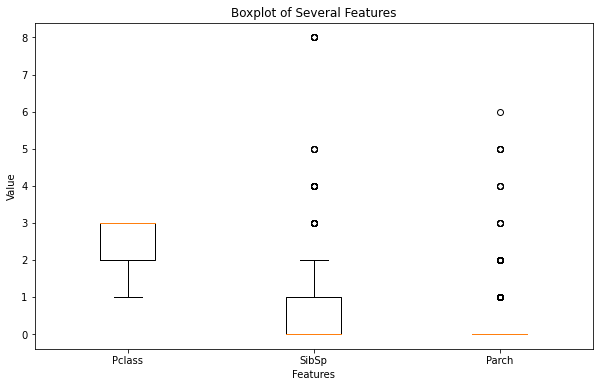

In [40]:
plot_boxplot(X_train_raw[['Pclass','SibSp','Parch']],['Pclass','SibSp','Parch'],
            'Boxplot of Several Features','Features','Value')

It seems like 'Parch' is pretty useless since most of the data are valued 0.\
Let's check it out

In [36]:
X_train_raw['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [37]:
X_train_raw['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Seems like 'SibSp' is not that useful as well.\
We will proceed first, if the correlation later supports this hypothesis, we will remove both 'Parch' and 'SibSp' to avoid confusing our model

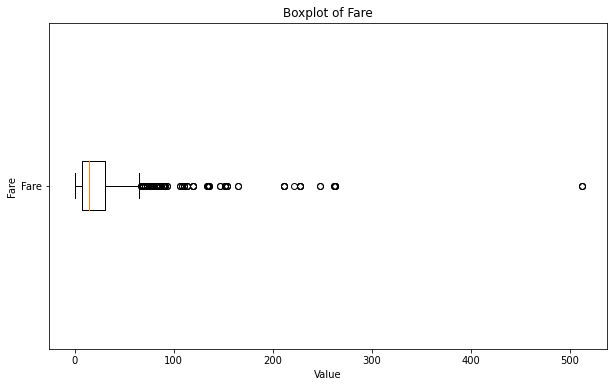

In [47]:
plot_boxplot(X_train_raw['Fare'],['Fare'],False,'Boxplot of Fare','Value','Fare')

There are quite some numbers of outliers to the 'Fare' attribute.\
But at this point of moment, we are unsure whether they provide positive or negative effect to the algorithm.\
As price is suspected to be highly related to survival rate, so outliers could possibly improve the True Positive rate when using model such as Logistic Regression Classification.

## Data Cleaning

### Age

Since 'Age' attribute has more than 100 NULL values.\
Our first objective is to determine whether we should drop the rows without 'Age'.

In [10]:
X_train_age = X_train_raw[['Age']].copy().dropna()
y_train_age = y_train_raw[X_train_age.index].copy()

In [12]:
X_train_age.isnull().any()

Age    False
dtype: bool

In [11]:
X_train_age.shape,y_train_age.shape

((714, 1), (714,))

In [14]:
Xy_train_age = pd.concat((X_train_age,y_train_age),axis=1)
Xy_train_age.corr()

,Age,Survived
Age,1.000000,-0.077221
Survived,-0.077221,1.000000


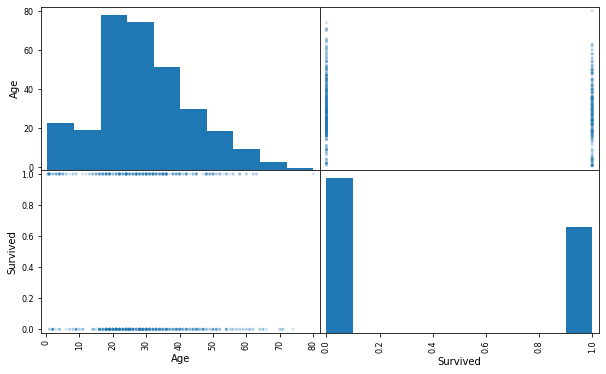

In [17]:
pd.plotting.scatter_matrix(Xy_train_age,alpha=0.2,figsize=(10,6))
plt.show()

It seems like there's higher survival chance for age between 20 to 40.\
Whereas for age > 60, the survival chance is pretty low (close to none).\
For age < 20, although the graphs show low density of dots, but that's mostly because there's less samples at this age group

We can say that age only has a mild effect on survival rate.\
Let's further confirm our hypothesis.

In [33]:
Xy_train_age['AgeGroup'] = pd.cut(Xy_train_age['Age'],[0,21,51,81],
                                 labels=['<20','20-50','>50'])
Xy_train_age.groupby('AgeGroup')[['Survived']].value_counts().unstack()

Survived,0,1
AgeGroup,,
<20,117,87
20-50,270,183
>50,37,20


Given we have 549 survives and 342 deaths in our raw dataset.\
The proportion between survives to deaths in different age groups are quite similar with the one in raw dataset.\
This suggests that age really doesn't quite matter to survival rate.

In [38]:
y_train_raw[X_train_raw['Age'].isnull()].value_counts()

0    125
1     52
Name: Survived, dtype: int64

With the 'Age' being NULL values, the train dataset has a lot more 0 than 1.\
If we replace all NULL values with the mean value, our algorithm might think that there's lesser survival chance for the 'Age' at mean age.\
This is possibly going to mislead our algorithm in the later stage.

To address to this issue, we will have to create a pipeline for this step itself so that we can optionally decide whether to replace the NULL values with mean age or not.

### Embarked

There's also 2 NULL values spotted in the column 'Embarked'.\
Since 2 samples are not that much valueble, we will just drop the two involving rows.

In [40]:
X_train_raw[X_train_raw['Embarked'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [42]:
X_train_embarked = X_train_raw[['Embarked']].copy().dropna()
y_train_embarked = y_train_raw[X_train_embarked.index].copy()

In [46]:
Xy_train_embarked = pd.concat((X_train_embarked,y_train_embarked),axis=1)

In [54]:
Xy_train_embarked_group = Xy_train_embarked.groupby('Embarked')[['Survived']].value_counts().unstack()
Xy_train_embarked_group['SurvivalRate'] = Xy_train_embarked_group[1]/Xy_train_embarked_group.sum(axis=1)
Xy_train_embarked_group

Survived,0,1,SurvivalRate
Embarked,,,
C,75,93,0.553571
Q,47,30,0.389610
S,427,217,0.336957


We can see that for some reason, the passenger departed from location 'C' seems to have slightly higher survival chance.\
It is difficult to tell the exact reason, some possible guess is the passengers departed from this location are arranged at a location closer to the safe spot/evacuation spot.\
Another possible reason is, this attribute is closely tied with another attribute which heavily correlated to survival rate. E.g. Most of the passengers departed from this location belongs to First Class Ticket.

We will drop the two rows with NULL values and proceed for now.

In [3]:
X_train = X_train_raw.dropna(subset=['Embarked']).copy()
X_train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [61]:
X_train['Embarked'].isnull().any()

False

### Cabin

This is a relatively hard to decide attribute due to there are only 200+ of non-NULL values.
The main reason why we cant easily decide what to do with this column is because if we choose to drop all NULL values of this column, we lost nearly 80% of our data from the dataset, that will render us only able to train any model with 200+ samples, which is unrealistic.

So what we can do here is to inspect closer to see whether there's a relation of Cabin Letter or Cabin Number to the Survival Rate or not.\
If after the inspection, we can safely believe that there is not much of a relation between those, we can drop this entire column.\
Else, we might need to train another mini model to address just with this column.

We will first write a function to extract Cabin Letter and Cabin Number from the given string

In [4]:
def extract_cabin(cabins_series:pd.Series):
    # print(cabins_series)
    cabin_letters_list = []
    cabin_numbers_list = []
    
    for cabins_s in cabins_series:
        cabins = cabins_s.strip().split()
        for cabin in cabins:
            cabin_letters = []
            cabin_numbers = []
            cabin = cabin.strip()
            if bool(re.match("^[A-Z][0-9]{1,3}$",cabin)):
                cabin_letters.append(cabin[0])
                cabin_numbers.append(int(cabin[1:]))
            elif bool(re.match("^[A-Z]$",cabin)):
                cabin_letters.append(cabin[0])
            else:
                continue
        else:
            cl_set = list(set(cabin_letters))
            cn_set = list(set(cabin_numbers))

            cl = cl_set[0]
            if cabin_numbers: cn = round(np.mean(cn_set))
            else: cn = None
            cabin_letters_list.append(cl)
            cabin_numbers_list.append(cn)
    else:
        # print(cabin_letters_list)
        # print(cabin_numbers_list)
        return pd.DataFrame((pd.Series(cabin_letters_list,name='C_Letters'),pd.Series(cabin_numbers_list,name='C_Numbers')))

Now we will create a copy of DataFrame where the cabin is not NULL values

In [5]:
X_train_cabin = X_train_raw[~X_train_raw['Cabin'].isnull()].copy()
y_train_cabin = y_train_raw[~X_train_raw['Cabin'].isnull()].copy()

In [242]:
X_train_cabin.shape,y_train_cabin.shape

((204, 10), (204,))

In [6]:
X_train_cabin = pd.concat((X_train_cabin,extract_cabin(X_train_cabin['Cabin']).T.set_index(X_train_cabin.index)),axis=1)[['Pclass','Cabin','C_Letters','C_Numbers']]
X_train_cabin

,Pclass,Cabin,C_Letters,C_Numbers
PassengerId,,,,
2,1,C85,C,85.0
4,1,C123,C,123.0
7,1,E46,E,46.0
11,3,G6,G,6.0
12,1,C103,C,103.0
...,...,...,...,...
872,1,D35,D,35.0
873,1,B51 B53 B55,B,55.0
880,1,C50,C,50.0


In [7]:
Xy_train_cabin = pd.concat((X_train_cabin,y_train_cabin),axis=1)

In [8]:
Xy_train_cabin_group = Xy_train_cabin.groupby('C_Letters')[['Survived']].value_counts().unstack()
Xy_train_cabin_group['SurvivalRate'] = Xy_train_cabin_group[1]/Xy_train_cabin_group.sum(axis=1)
Xy_train_cabin_group

Survived,0,1,SurvivalRate
C_Letters,,,
A,8.0,7.0,0.466667
B,12.0,35.0,0.744681
C,24.0,35.0,0.593220
D,8.0,25.0,0.757576
E,8.0,25.0,0.757576
F,2.0,7.0,0.777778
G,5.0,2.0,0.285714
T,1.0,NaN,NaN


By looking at the plan of Titanic ship, we can notice that deck A is actually the closest to the Boat Deck where all the safe boats are located.\
Deck A, B and C also are the decks that are exclusive for First Class passengers.\
Moreover, Titanic ship wreck started at about 2:20 AM, which should make cabin location prominent for survivals.

Yet, cabin letter A still has the the second lowest survival rate.\
This could be highly possibly due to the lack of samples (only 200+ non-NULL values).

This should suggests that the 'Cabin' might not be as useful for the algorithm training and predicting.

![Titanic Plan](Images\\Titanic_Plan.png)

Now, let us plot the survivals against the Cabin numbers.\
This is to investigate whether is certain spot on the ship is actually safer than others.

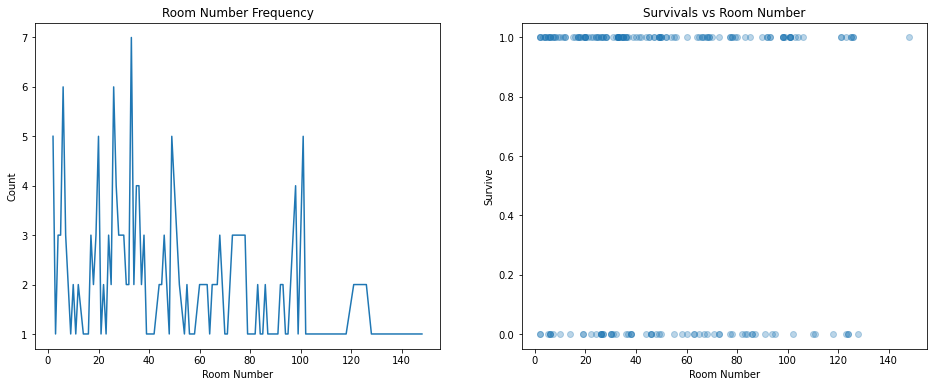

In [41]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
# fig(12,6)
Xy_train_cabin['C_Numbers'].value_counts().sort_index().plot(title='Room Number Frequency',
                                                            xlabel='Room Number',
                                                            ylabel='Count',ax=ax[0])
plt.scatter(Xy_train_cabin['C_Numbers'],Xy_train_cabin['Survived'],alpha=0.3,axes=ax[1])
plt.title('Survivals vs Room Number')
plt.xlabel('Room Number')
plt.ylabel('Survive')
plt.show()

Although looking at the scatter plot above, we might notice that there's higher density in successful survival for room number 0 to 40 range.\
But when we combine with the 'Room Number Frequency' chart, it is clear that our samples mostly composed of room number 0 to 40 range.

This also further suggests that either there's insufficient information for the column 'Cabin' or the 'Cabin' is just not really correlated to the survival chance.

So we will drop the entire column 'Cabin'

In [44]:
X_train = X_train.drop('Cabin',axis=1)

In [45]:
X_train.shape

(889, 9)

### Name

Since I can't logically link Name with survival chance and every passenger has different name with each others.\
I doubt it will be any useful helping them survive the ship wreck.

As a result, I will drop this entire column as well.

In [46]:
X_train = X_train.drop('Name',axis=1)

In [47]:
X_train.shape

(889, 8)

### Ticket

In [50]:
X_train['Ticket'].values[:50]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '349909', '347077', '2631', '19950', '330959', '349216',
       'PC 17601', 'PC 17569', '335677', 'C.A. 24579', 'PC 17604',
       '113789', '2677', 'A./5. 2152', '345764', '2651', '7546', '11668',
       '349253', 'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371',
       '14311', '2662', '349237'], dtype=object)

We can see that the ticket are quite unstandardized.\
Since most algorithm only accepts numerical elements as input and I cant quite link logically the relation of the front part (e.g. A/5) with the survival chance.\
So we will trim the ticket, taking only the back portion, which is an integer.

In [75]:
X_train['Ticket'] = X_train['Ticket'].str.extract("([0-9]+$)")
X_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,
1,3,male,22.0,1,0,21171,7.2500,S
2,1,female,38.0,1,0,17599,71.2833,C
3,3,female,26.0,0,0,3101282,7.9250,S
4,1,female,35.0,1,0,113803,53.1000,S
5,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...
887,2,male,27.0,0,0,211536,13.0000,S
888,1,female,19.0,0,0,112053,30.0000,S
889,3,female,NaN,1,2,6607,23.4500,S


In [79]:
X_train[X_train['Ticket'].isnull()]['Ticket']

PassengerId
180    NaN
272    NaN
303    NaN
598    NaN
Name: Ticket, dtype: object

There are 4 records where the ticker value is 'LINE'.\
After trying to extract integer from the ticket value, it generates nothing due to no integer at all is available.\

We will also drop these involving rows.

In [80]:
X_train = X_train.dropna(subset='Ticket')
X_train

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,
1,3,male,22.0,1,0,21171,7.2500,S
2,1,female,38.0,1,0,17599,71.2833,C
3,3,female,26.0,0,0,3101282,7.9250,S
4,1,female,35.0,1,0,113803,53.1000,S
5,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...
887,2,male,27.0,0,0,211536,13.0000,S
888,1,female,19.0,0,0,112053,30.0000,S
889,3,female,NaN,1,2,6607,23.4500,S


Now that we have a relatively clean training data.\
We just need to cast all the categorical columns into numbers.

We will use Ordinal Encoder for 'Sex' and One Hot Encoder for 'Embarked'

In [82]:
sex_encoder = OrdinalEncoder()

In [93]:
X_train['Sex'] = sex_encoder.fit_transform(X_train[['Sex']])
X_train

C:\Users\pi314\AppData\Local\Temp\ipykernel_12156\208115396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Sex'] = sex_encoder.fit_transform(X_train[['Sex']])


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,
1,3,1.0,22.0,1,0,21171,7.2500,S
2,1,0.0,38.0,1,0,17599,71.2833,C
3,3,0.0,26.0,0,0,3101282,7.9250,S
4,1,0.0,35.0,1,0,113803,53.1000,S
5,3,1.0,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...
887,2,1.0,27.0,0,0,211536,13.0000,S
888,1,0.0,19.0,0,0,112053,30.0000,S
889,3,0.0,NaN,1,2,6607,23.4500,S


In [95]:
sex_encoder.categories_

[array(['female', 'male'], dtype=object)]

In [103]:
embarked_encoder = OneHotEncoder(sparse=False)

In [122]:
embarked_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [123]:
X_train[['C', 'Q', 'S']] = embarked_encoder.fit_transform(X_train[['Embarked']])
X_train

C:\Users\pi314\AppData\Local\Temp\ipykernel_12156\3235471330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['C', 'Q', 'S']] = embarked_encoder.fit_transform(X_train[['Embarked']])
C:\Users\pi314\AppData\Local\Temp\ipykernel_12156\3235471330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['C', 'Q', 'S']] = embarked_encoder.fit_transform(X_train[['Embarked']])
C:\Users\pi314\AppData\Local\Temp\ipykernel_12156\3235471330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,C,Q,S
PassengerId,,,,,,,,,,,
1,3,1.0,22.0,1,0,21171,7.2500,S,0.0,0.0,1.0
2,1,0.0,38.0,1,0,17599,71.2833,C,1.0,0.0,0.0
3,3,0.0,26.0,0,0,3101282,7.9250,S,0.0,0.0,1.0
4,1,0.0,35.0,1,0,113803,53.1000,S,0.0,0.0,1.0
5,3,1.0,35.0,0,0,373450,8.0500,S,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
887,2,1.0,27.0,0,0,211536,13.0000,S,0.0,0.0,1.0
888,1,0.0,19.0,0,0,112053,30.0000,S,0.0,0.0,1.0
889,3,0.0,NaN,1,2,6607,23.4500,S,0.0,0.0,1.0


In [126]:
X_train = X_train.drop('Embarked',axis=1)

In [192]:
X_train['Ticket'] = X_train['Ticket'].astype('int')

In [193]:
Xy_train = pd.concat((X_train,y_train_raw),axis=1,join='inner')

In [194]:
Xy_train.corr()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,C,Q,S,Survived
Pclass,1.000000,0.125344,-0.368364,0.083599,0.018632,0.286102,-0.547142,-0.244438,0.222096,0.074344,-0.335705
Sex,0.125344,1.000000,0.098609,-0.114968,-0.246358,0.076637,-0.178196,-0.083061,-0.074300,0.119604,-0.542402
Age,-0.368364,0.098609,1.000000,-0.307621,-0.187863,-0.106422,0.094094,0.038845,-0.021529,-0.026044,-0.081042
SibSp,0.083599,-0.114968,-0.307621,1.000000,0.413945,0.045731,0.159731,-0.061174,-0.027373,0.070860,-0.034711
Parch,0.018632,-0.246358,-0.187863,0.413945,1.000000,-0.033843,0.216461,-0.012636,-0.082305,0.062920,0.082770
Ticket,0.286102,0.076637,-0.106422,0.045731,-0.033843,1.000000,-0.156484,-0.194984,-0.003683,0.173219,-0.095778
Fare,-0.547142,-0.178196,0.094094,0.159731,0.216461,-0.156484,1.000000,0.269718,-0.117720,-0.162249,0.255234
C,-0.244438,-0.083061,0.038845,-0.061174,-0.012636,-0.194984,0.269718,1.000000,-0.149429,-0.782352,0.169793
Q,0.222096,-0.074300,-0.021529,-0.027373,-0.082305,-0.003683,-0.117720,-0.149429,1.000000,-0.498938,0.004165
S,0.074344,0.119604,-0.026044,0.070860,0.062920,0.173219,-0.162249,-0.782352,-0.498938,1.000000,-0.151443


In [202]:
Xy_train_corr = Xy_train.corr().values
np.fill_diagonal(Xy_train_corr,0)
Xy_train_corr

array([[ 0.        ,  0.12534432, -0.36836376,  0.08359936,  0.01863177,
         0.28610212, -0.54714153, -0.24443804,  0.22209616,  0.07434422,
        -0.33570491],
       [ 0.12534432,  0.        ,  0.09860886, -0.114968  , -0.24635789,
         0.0766367 , -0.17819573, -0.0830614 , -0.07429999,  0.11960378,
        -0.54240183],
       [-0.36836376,  0.09860886,  0.        , -0.30762083, -0.18786333,
        -0.10642198,  0.09409409,  0.03884504, -0.02152923, -0.02604364,
        -0.08104224],
       [ 0.08359936, -0.114968  , -0.30762083,  0.        ,  0.41394459,
         0.04573142,  0.15973121, -0.06117395, -0.02737291,  0.0708601 ,
        -0.03471094],
       [ 0.01863177, -0.24635789, -0.18786333,  0.41394459,  0.        ,
        -0.0338426 ,  0.21646103, -0.01263634, -0.08230479,  0.06292003,
         0.08277039],
       [ 0.28610212,  0.0766367 , -0.10642198,  0.04573142, -0.0338426 ,
         0.        , -0.1564837 , -0.1949839 , -0.00368303,  0.17321914,
        -0.095

In [189]:
Xy_train.columns.values

array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'C',
       'Q', 'S', 'Survived'], dtype=object)

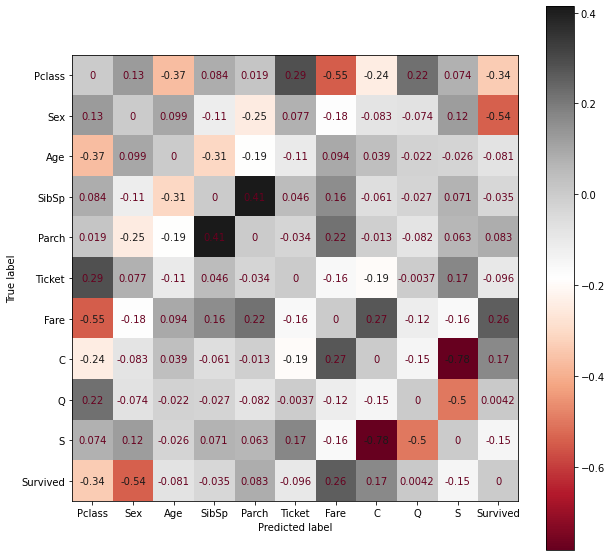

In [207]:
plt.figure(figsize=(10,10))
ax=plt.gca()
ConfusionMatrixDisplay(Xy_train_corr,display_labels=Xy_train.columns.values).plot(cmap='RdGy',ax=ax)
plt.show()

We make use of the confusion matric display class to plot the correlation diagram here.\

From the diagram, we can see that the most important factors correlated to survival rate are 'Pclass', 'Sex', and 'Fare'.\
Where 'Fare' and 'Pclass' are correlated with each other.\
In the case of our model not performing as good, we can reduce these two features into one and see how's the effect.

Just to be safe, we also plot the scatter matrix to visually check the relationship between all features.

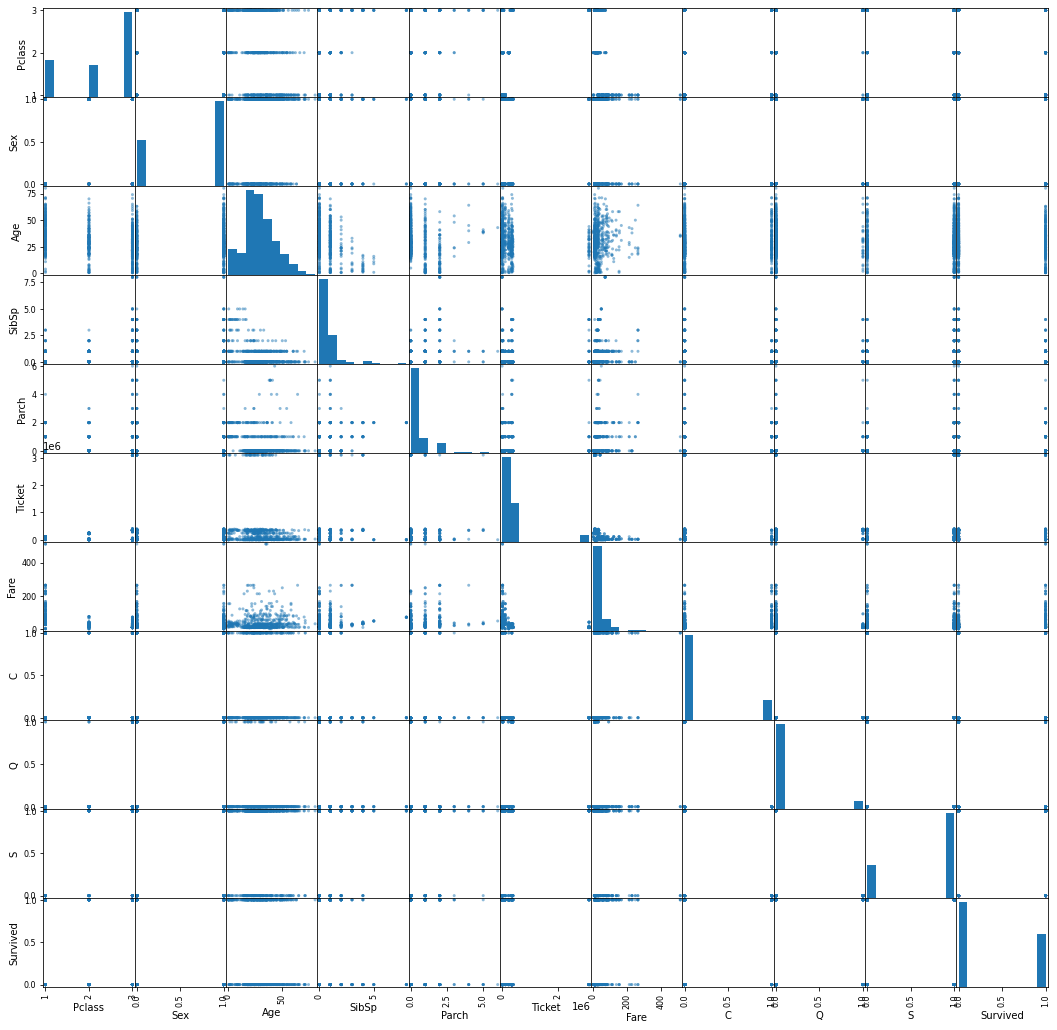

In [213]:
pd.plotting.scatter_matrix(Xy_train,figsize=(18,18),grid=True)
plt.show()

## Initial Trying 

Let's try out with a few of the common classification algorithm and see which one performs the best.\
We will then try again with the normalized training dataset.\
After that, we will try the same set of algorithms on the X dataset with only core features.

In [304]:
estimators = [SVC,LinearSVC,SGDClassifier,RidgeClassifier,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression]
results = test_water(estimators,X_train,y_train,scoring=['accuracy','f1'],return_train_score=True)
results.groupby('estimator').mean()

,run,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
estimator,,,,,,,
DecisionTreeClassifier,1.5,0.003907,0.000000,0.734463,1.000000,0.674501,1.000000
KNeighborsClassifier,1.5,0.001749,0.001285,0.670904,0.774482,0.597046,0.713883
LinearSVC,1.5,0.019536,0.000000,0.464689,0.457156,0.407580,0.398824
LogisticRegression,1.5,0.003908,0.000000,0.581921,0.620056,0.125000,0.165272
RidgeClassifier,1.5,0.007815,0.000000,0.786723,0.798964,0.724882,0.741641
SGDClassifier,1.5,0.007814,0.000000,0.548023,0.545669,0.144578,0.144102
SVC,1.5,0.013749,0.010250,0.573446,0.601695,0.120482,0.152805


In [267]:
myscaler = MyScaler('std')
X_train_norm = myscaler.fit_transform(X_train)
X_train_norm

array([[ 0.91329515,  0.75949813, -0.5261397 , ..., -0.47425046,
        -0.20291986,  0.53597829],
       [-1.47714095, -1.31665893,  0.57754972, ...,  2.10859049,
        -0.20291986, -1.86574721],
       [ 0.91329515, -1.31665893, -0.25021734, ..., -0.47425046,
        -0.20291986,  0.53597829],
       ...,
       [-1.47714095, -1.31665893, -0.73308146, ..., -0.47425046,
        -0.20291986,  0.53597829],
       [-1.47714095,  0.75949813, -0.25021734, ...,  2.10859049,
        -0.20291986, -1.86574721],
       [ 0.91329515,  0.75949813,  0.16366619, ..., -0.47425046,
         4.9280538 , -1.86574721]])

In [303]:
estimators = [SVC,LinearSVC,SGDClassifier,RidgeClassifier,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression]
results_norm = test_water(estimators,X_train_norm,y_train,scoring=['accuracy','f1'],return_train_score=True)
results_norm.groupby('estimator').mean()

,run,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
estimator,,,,,,,
DecisionTreeClassifier,1.5,0.000000,0.000000,0.752825,1.000000,0.693918,1.000000
KNeighborsClassifier,1.5,0.000000,0.007815,0.790960,0.854520,0.730349,0.811802
LinearSVC,1.5,0.019533,0.003908,0.786723,0.800847,0.724072,0.745008
LogisticRegression,1.5,0.003907,0.000000,0.785311,0.804614,0.720515,0.748916
RidgeClassifier,1.5,0.003908,0.003908,0.786723,0.797552,0.724882,0.739675
SGDClassifier,1.5,0.003908,0.000000,0.752825,0.763183,0.694915,0.705187
SVC,1.5,0.007815,0.105845,0.807910,0.844162,0.733763,0.787790


In [305]:
X_train_cut = X_train[['Pclass','Fare','Sex','C']].copy()
estimators = [SVC,LinearSVC,SGDClassifier,RidgeClassifier,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression]
results_cut = test_water(estimators,X_train_cut,y_train,scoring=['accuracy','f1'],return_train_score=True)
results_cut.groupby('estimator').mean()

,run,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
estimator,,,,,,,
DecisionTreeClassifier,1.5,0.000000,0.000000,0.785311,0.911017,0.712387,0.881636
KNeighborsClassifier,1.5,0.001249,0.010815,0.744350,0.821092,0.659450,0.769189
LinearSVC,1.5,0.015630,0.000000,0.758475,0.776365,0.699969,0.719018
LogisticRegression,1.5,0.000000,0.003908,0.766949,0.776836,0.706505,0.724439
RidgeClassifier,1.5,0.003908,0.000000,0.768362,0.780603,0.706543,0.725509
SGDClassifier,1.5,0.007816,0.000000,0.646893,0.678908,0.491297,0.523407
SVC,1.5,0.012500,0.011017,0.663842,0.671375,0.427945,0.438359


Let's try another approach with 'Age' NULL value being filled with mean age value.

In [285]:
X_train_agefilled = Xy_train.loc[:,'Pclass':'S'].copy()
X_train_agefilled['Age'].fillna(X_train_agefilled['Age'].mean(),inplace=True)
X_train_agefilled

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,C,Q,S
PassengerId,,,,,,,,,,
1,3,1.0,22.000000,1,0,21171,7.2500,0.0,0.0,1.0
2,1,0.0,38.000000,1,0,17599,71.2833,1.0,0.0,0.0
3,3,0.0,26.000000,0,0,3101282,7.9250,0.0,0.0,1.0
4,1,0.0,35.000000,1,0,113803,53.1000,0.0,0.0,1.0
5,3,1.0,35.000000,0,0,373450,8.0500,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
887,2,1.0,27.000000,0,0,211536,13.0000,0.0,0.0,1.0
888,1,0.0,19.000000,0,0,112053,30.0000,0.0,0.0,1.0
889,3,0.0,29.627359,1,2,6607,23.4500,0.0,0.0,1.0


In [287]:
X_train_agefilled_norm = myscaler.fit_transform(X_train_agefilled)
X_train_agefilled_norm

array([[ 8.28347142e-01,  7.37904206e-01, -5.88242063e-01, ...,
        -4.84055393e-01, -3.08702170e-01,  6.18718434e-01],
       [-1.56736273e+00, -1.35518946e+00,  6.45720218e-01, ...,
         2.06587927e+00, -3.08702170e-01, -1.61624407e+00],
       [ 8.28347142e-01, -1.35518946e+00, -2.79751493e-01, ...,
        -4.84055393e-01, -3.08702170e-01,  6.18718434e-01],
       ...,
       [ 8.28347142e-01, -1.35518946e+00, -2.73994667e-16, ...,
        -4.84055393e-01, -3.08702170e-01,  6.18718434e-01],
       [-1.56736273e+00,  7.37904206e-01, -2.79751493e-01, ...,
         2.06587927e+00, -3.08702170e-01, -1.61624407e+00],
       [ 8.28347142e-01,  7.37904206e-01,  1.82984363e-01, ...,
        -4.84055393e-01,  3.23936822e+00, -1.61624407e+00]])

In [289]:
y_train_agefilled_norm = y_train_raw[X_train_agefilled.index]

In [306]:
# X_train_agefilled_norm = X_train[['Pclass','Fare','Sex','C']].copy()
estimators = [SVC,LinearSVC,SGDClassifier,RidgeClassifier,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression]
results_agefilled_norm = test_water(estimators,X_train_agefilled_norm,y_train_agefilled_norm,scoring=['accuracy','f1'],return_train_score=True)
results_agefilled_norm.groupby('estimator').mean()

,run,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
estimator,,,,,,,
DecisionTreeClassifier,1.5,0.003907,0.003907,0.768370,0.998870,0.699311,0.998527
KNeighborsClassifier,1.5,0.001000,0.002515,0.803443,0.859889,0.728426,0.808897
LinearSVC,1.5,0.023444,0.000000,0.792095,0.802262,0.717486,0.730902
LogisticRegression,1.5,0.003908,0.000000,0.794367,0.804900,0.719941,0.735814
RidgeClassifier,1.5,0.000000,0.000000,0.793216,0.803392,0.719683,0.733388
SGDClassifier,1.5,0.007816,0.000000,0.697194,0.732197,0.614568,0.668736
SVC,1.5,0.013250,0.010753,0.823743,0.846329,0.743683,0.777235


In [299]:
X_train_agefilled_minmax = myscaler.fit_transform(X_train_agefilled,scalertype='minmax')
X_train_agefilled_minmax

array([[1.        , 1.        , 0.27117366, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.4722292 , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.32143755, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.        , 0.36701883, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.32143755, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.39683338, ..., 0.        , 1.        ,
        0.        ]])

In [300]:
y_train_agefilled_minmax = y_train_raw[X_train_agefilled.index]

Another approach of trying to normalize training dataset with minmax method

In [307]:
# X_train_agefilled_norm = X_train[['Pclass','Fare','Sex','C']].copy()
estimators = [SVC,LinearSVC,SGDClassifier,RidgeClassifier,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression]
results_agefilled_minmax = test_water(estimators,X_train_agefilled_minmax,y_train_agefilled_minmax,scoring=['accuracy','f1'],return_train_score=True)
results_agefilled_minmax.groupby('estimator').mean()

,run,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
estimator,,,,,,,
DecisionTreeClassifier,1.5,0.007815,0.000000,0.759325,0.998870,0.691225,0.998527
KNeighborsClassifier,1.5,0.000000,0.003908,0.811346,0.854243,0.734210,0.799836
LinearSVC,1.5,0.000000,0.000000,0.793216,0.804145,0.720433,0.733302
LogisticRegression,1.5,0.002781,0.000000,0.794347,0.804521,0.720520,0.734779
RidgeClassifier,1.5,0.000000,0.000000,0.794347,0.803391,0.718863,0.733383
SGDClassifier,1.5,0.003908,0.000000,0.690667,0.679375,0.586627,0.582722
SVC,1.5,0.014499,0.010502,0.810189,0.818079,0.702929,0.717289


Looks like the best approach would be a SVC model with normalized dataset with standard scaler and with full features.\
NULL values in 'Age' should be replaced with the mean value for higher accuracy as that grants another 177 samples to training the model.\
And it seems like the model still has some room for improvement, we will try tuning with the hyperparameters of the algorithm in the later stage.

This concludes the data exploration stage.\
Next up, we will create a pipeline in another notebook that convert and fit the trainning and test dataset from end to end.